In [13]:
import os
from functools import partial

os.environ["JAX_ENABLE_X64"] = "True"

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_exponential
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_galaxy_params_skew,
    sample_ellip_prior
)
from bpd.utils import DEFAULT_HYPERPARAMS, MAX_N_GALS_PER_GPU, process_in_batches

import matplotlib.pyplot as plt 

import numpy as np 

from tqdm import tqdm
import jax

In [2]:
jax.devices()

[CudaDevice(id=0)]

In [3]:
# compute effective sample size and r-hat
from arviz import ess
from blackjax.diagnostics import potential_scale_reduction

def get_ess_all(samples: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    """Obtain ESS for all chains and parameters."""
    print("INFO: Computing ESS...")
    n_gals, n_chains_per_gal, n_samples_per_gal = samples["lf"].shape

    n_samples = n_chains_per_gal * n_samples_per_gal
    ess_dict = {}

    for ii in tqdm(range(n_gals)):
        params = {k: v[ii] for k, v in samples.items()}
        value = ess(params)

        for k in samples:
            kval = value[k].data.item() / n_samples
            if k not in ess_dict:
                ess_dict[k] = [kval]
            else:
                ess_dict[k].append(kval)
    ess_dict = {k: np.array(v) for k, v in ess_dict.items()}
    return ess_dict


def get_rhat_all(samples: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    """Obtain r-hats for all chains and parameters."""
    print("INFO: Computing R-hats...")
    n_gals, n_chains_per_gal, n_samples = samples["lf"].shape

    rhat_dict = {}
    for p in samples:
        rhat = []
        for ii in tqdm(range(n_gals)):
            chains = samples[p][ii]
            assert chains.shape == (n_chains_per_gal, n_samples)
            rhat.append(potential_scale_reduction(chains))
        rhat_dict[p] = np.array(rhat)

    return rhat_dict


In [4]:
from ornax.hmc import ensemble_hmc
from ornax.nested_sampling import nested_sampler_hmc

In [5]:
def _init_fnc(key: PRNGKeyArray, *, data: Array, true_params: dict):
    image = data
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()

    k1, k2, k3, k4, k5, k6 = random.split(key, 6)

    _lf = jnp.log10(flux)
    lf = random.uniform(k1, shape=(), minval=_lf - 0.01, maxval=_lf + 0.01)

    tlhlr = true_params["lhlr"]
    lhlr = random.uniform(k2, shape=(), minval=tlhlr - 0.015, maxval=tlhlr + 0.015)

    te1 = true_params["e1"]
    e1 = random.uniform(k3, shape=(), minval=te1 - 0.1, maxval=te1 + 0.1)

    te2 = true_params["e2"]
    e2 = random.uniform(k4, shape=(), minval=te2 - 0.1, maxval=te2 + 0.1)
    return {
        "lf": lf,
        "lhlr": lhlr,
        "e1": e1,
        "e2": e2,
        "dx": random.uniform(k5, shape=(), minval=-0.1, maxval=0.1),
        "dy": random.uniform(k6, shape=(), minval=-0.1, maxval=0.1),
    }

In [6]:
def initialize_params(key, image, true_params):
    return _init_fnc(key, data=image, true_params=true_params)

In [7]:
seed = 42 
n_gals: int = 500
n_samples_per_gal: int = 300
sigma_e_int: float = 0.3
g1: float = 0.02
g2: float = 0.0
slen: int = 63
fft_size: int = 256
background: float = 1.0

_params_order = ('lf', 'lhlr', 'dx', 'dy', 'e1', 'e2',)

In [8]:
rng_key = random.key(seed)
pkey, nkey, gkey = random.split(rng_key, 3)

In [9]:

# galaxy parameters from prior
galaxy_params = sample_galaxy_params_skew(
    pkey, n=n_gals, g1=g1, g2=g2, **DEFAULT_HYPERPARAMS
)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen, draw_type="exponential"
)
assert target_images.shape == (n_gals, slen, slen)

# interim samples are on 'sheared ellipticity'
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
true_params["dx"] = jnp.zeros_like(true_params["x"])
true_params["dy"] = jnp.zeros_like(true_params["y"])
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
}


In [10]:
true_params['e1'].shape

(500,)

In [24]:
from bpd.prior import ellip_prior_e1e2
from jax.scipy import stats



def logprior_flat(
    x: Array,
    *,
    sigma_e: float,
    sigma_x: float = 0.5,  # pixels
    flux_bds: tuple = (-1.0, 9.0),
    hlr_bds: tuple = (-2.0, 1.0),
):
    assert x.shape == (6,)
    prior = jnp.array(0.0)
    lf, lhlr, dx, dy, e1, e2 = x

    f1, f2 = flux_bds
    prior += stats.uniform.logpdf(lf, f1, f2 - f1)

    h1, h2 = hlr_bds
    prior += stats.uniform.logpdf(lhlr, h1, h2 - h1)

    prior += stats.norm.logpdf(dx, loc=0.0, scale=sigma_x)
    prior += stats.norm.logpdf(dy, loc=0.0, scale=sigma_x)

    e1e2 = jnp.stack((e1, e2), axis=-1)
    prior += jnp.log(ellip_prior_e1e2(e1e2, sigma=sigma_e))

    return prior



def prior_draw(
    rng_key,
    *,
    sigma_e: float,
    sigma_x: float = 0.5,  # pixels
    flux_bds: tuple = (-1.0, 9.0),
    hlr_bds: tuple = (-2.0, 1.0),
):
    k1, k2, k3, k4, k5= random.split(rng_key, 5)

    f1, f2 = flux_bds
    lf = random.uniform(k1, minval=f1, maxval=f2)

    h1, h2 = hlr_bds
    lhlr = random.uniform(k2, minval=h1, maxval=h2)

    dx = random.normal(k3) * sigma_x
    dy = random.normal(k4) * sigma_x


    e1e2 = sample_ellip_prior(k5, sigma=sigma_e, n=1)
    e1=e1e2[0, 0]
    e2=e1e2[0, 1]

    return jnp.array([lf, lhlr, dx, dy, e1, e2])

In [26]:
def gaussian_image_loglikelihood_flat(
    x:Array,
    data: Array,
    fixed_params: dict[str, Array],
    *,
    draw_fnc,
    background: float,
):
    assert x.shape == (6,)
    assert data.ndim == 2
    _draw_params = {}
    lf, lhlr, dx, dy, e1, e2 = x

    _draw_params["x"] = dx + fixed_params["x"]
    _draw_params["y"] = dy + fixed_params["y"]
    _draw_params["f"] = 10 ** lf
    _draw_params["hlr"] = 10 ** lhlr
    _draw_params["e1"] = e1
    _draw_params["e2"] = e2
    model = draw_fnc(**_draw_params)
    likelihood_pp = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(background))
    return jnp.sum(likelihood_pp)


In [28]:
# setup prior and likelihood
_logprior = partial(
    logprior_flat,
    sigma_e=sigma_e_int,
)
_draw_fnc = partial(draw_exponential, slen=slen, fft_size=fft_size)
_loglikelihood = partial(
    gaussian_image_loglikelihood_flat,
    draw_fnc=_draw_fnc,
    background=background,
)
_prior_draw = partial(
    prior_draw, sigma_e=sigma_e_int
)

In [31]:
n_dims = 6 # number of parameters
n_live=1000
# n_walkers = max(2 * n_dims, 10)
# n_walkers=10
# leapfrog_step_size=0.5
# n_leapfrog_steps=2
# leapfrog_step_size=0.05
# n_leapfrog_steps=20
# leapfrog_step_size=None
# n_leapfrog_steps=None
# n_samples=1000

In [48]:
def run_ensemble_hmc(rng_key, data, fixed_params, *, logprior, loglikelihood, prior_draw,
                     n_live=1000, n_dims=6):
    _loglike = partial(loglikelihood, data=data, fixed_params=fixed_params)

    return nested_sampler_hmc(rng_key, log_likelihood=_loglike, log_prior=logprior, n_dims=n_dims, n_live=n_live, prior_draw=prior_draw, verbose=False)
    

In [49]:
run_nested = jit(partial(run_ensemble_hmc, loglikelihood=_loglikelihood, logprior=_logprior, prior_draw=_prior_draw, n_dims=n_dims, n_live=n_live))

In [50]:
run_nested(rng_key, target_images[0], 
           {k:v[0] for k,v in fixed_params.items()})

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function run_ensemble_hmc at /tmp/ipykernel_50007/1115835504.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments rng_key, data, fixed_params['x'], and fixed_params['y'].
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
run_nested(rng_key

In [520]:
def my_logtarget(x:Array, *, data, fixed_params, logprior, loglikelihood):
    return logprior(x) + loglikelihood(x, data, fixed_params)
    

In [521]:
def run_ensemble_hmc(rng_key, data, init_positions, fixed_params, *, logprior, loglikelihood, 
                     n_samples=500, n_walkers=12, leapfrog_step_size=None, n_leapfrog_steps=None):

    _logtarget = partial(my_logtarget, data=data, fixed_params=fixed_params, logprior=logprior, loglikelihood=loglikelihood)
    chain, acc, loglike = ensemble_hmc(rng_key, _logtarget, n_dims=6, n_samples=n_samples, params_init=init_positions, verbose=False, 
                                       n_walkers=n_walkers, 
                                       leapfrog_step_size=leapfrog_step_size, 
                                       n_leapfrog_steps=n_leapfrog_steps)

    return chain, acc, loglike

_pipe = partial(run_ensemble_hmc, logprior=_logprior, loglikelihood=_loglikelihood, 
                n_walkers=n_walkers, leapfrog_step_size=leapfrog_step_size, n_leapfrog_steps=n_leapfrog_steps, n_samples=n_samples)

In [522]:
init_key, run_key = random.split(gkey)

In [523]:
# vmap(initialize_params)(random.split(init_key, (n_gals,)), target_images, true_params)

In [524]:
_init_keys = random.split(init_key, (n_gals, n_walkers))
_init_vectorized = vmap(vmap(initialize_params, in_axes=(0,None, None)))
init_params = _init_vectorized(_init_keys, target_images, true_params)

In [525]:
init_params['e1'].shape, _params_order

((500, 12), ('lf', 'lhlr', 'dx', 'dy', 'e1', 'e2'))

In [526]:
init_params['lf'][0]

Array([2.60670042, 2.61892002, 2.61695047, 2.62420442, 2.62148852,
       2.61729489, 2.61227229, 2.62382496, 2.61948872, 2.62063361,
       2.62056075, 2.61114065], dtype=float64)

In [527]:
# convert to array in the correct order
_init_params_array = np.zeros((n_gals, n_walkers, 6))
for ii, k in enumerate(_params_order):
    _init_params_array[..., ii] = init_params[k]
    
_init_params_array = jnp.array(_init_params_array)
_init_params_array.shape, _init_params_array.devices()

((500, 12, 6), {CudaDevice(id=0)})

In [528]:
run_keys = random.split(run_key, n_gals)
run_keys.shape

(500,)

In [529]:
fixed_params['x'].shape

(500,)

In [530]:
np.where(true_params['lf'] > 3.4), true_params['lf'][84]

((array([  4,  31,  47,  84, 172, 254, 283, 288, 292, 300, 381, 460, 476]),),
 Array(3.58654902, dtype=float64))

# Sanity check and jit one example

In [531]:
pipe = jit(_pipe)

In [532]:
idx = 47

samples, _, _ = pipe(run_keys[idx],
     target_images[idx],
     _init_params_array[idx],
     {k:v[idx] for k,v in fixed_params.items()},
    )

In [533]:
samples.shape

(1000, 12, 6)

In [534]:

samples_dict = {} 
for jj, p in enumerate(_params_order):
    samples_dict[p] = samples[100:, :, jj].T.reshape(1, 12, -1) # 100 burn in samples


ess_out = get_ess_all(samples_dict)
rhat_out = get_rhat_all(samples_dict)

ess_out, rhat_out

INFO: Computing ESS...


100%|██████████| 1/1 [00:00<00:00, 30.29it/s]


INFO: Computing R-hats...


100%|██████████| 1/1 [00:00<00:00, 916.19it/s]


({'lf': array([0.18152194]),
  'lhlr': array([0.19966185]),
  'dx': array([0.18791574]),
  'dy': array([0.22287877]),
  'e1': array([0.19263801]),
  'e2': array([0.20611784])},
 {'lf': array([1.0029404]),
  'lhlr': array([1.00208631]),
  'dx': array([1.00222757]),
  'dy': array([1.00225115]),
  'e1': array([1.00119487]),
  'e2': array([1.00103015])})

In [535]:
samples_dict['lf'].shape

(1, 12, 900)

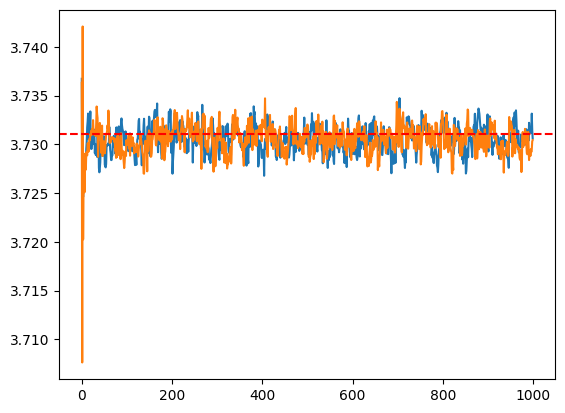

In [536]:
for ii in range(2):

    plt.plot(samples[:,ii, 0])
plt.axhline(true_params['lf'][idx], c='r', ls='--')


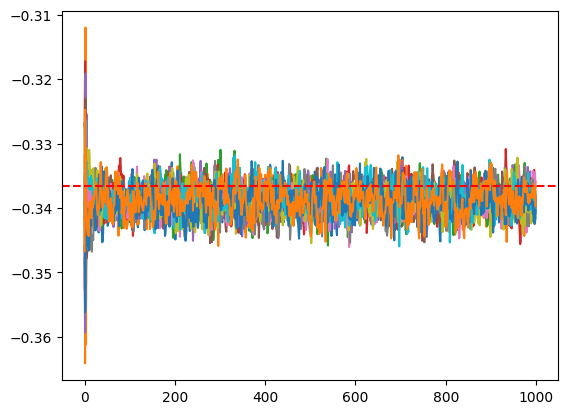

In [537]:
for ii in range(12):
    plt.plot(samples[:,ii, 1])
plt.axhline(true_params['lhlr'][idx], c='r', ls='--')


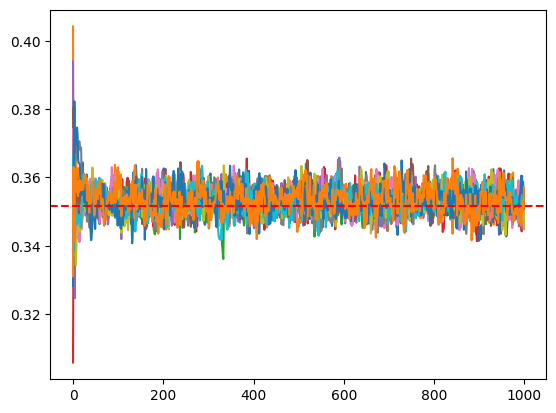

In [538]:
for ii in range(12):
    plt.plot(samples[:,ii, 4])
plt.axhline(true_params['e1'][idx], c='r', ls='--')

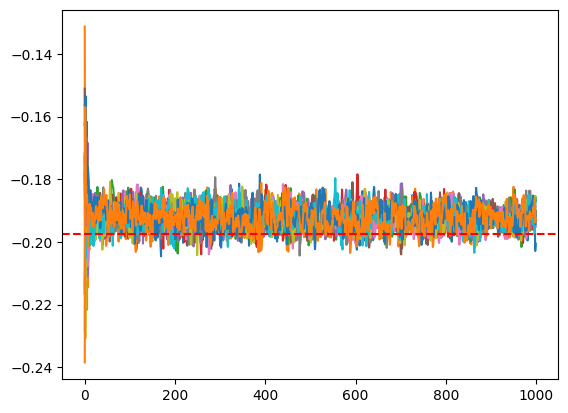

In [539]:
for ii in range(12):
    plt.plot(samples[:,ii, 5])
plt.axhline(true_params['e2'][idx], c='r', ls='--')

# Vectorize

In [540]:
# samples, _ , _ = vmap(pipe)(run_keys[:10],
#      target_images[:10],
#      _init_params_array[:10],
#      {k:v[:10] for k,v in fixed_params.items()}
#     )


In [4]:
# samples, _ , _ = vmap(pipe)(run_keys,
#      target_images,
#      _init_params_array,
#      fixed_params,
#     )
# # > 5 min

In [5]:
samples.shape

(500, 1000, 12, 6)

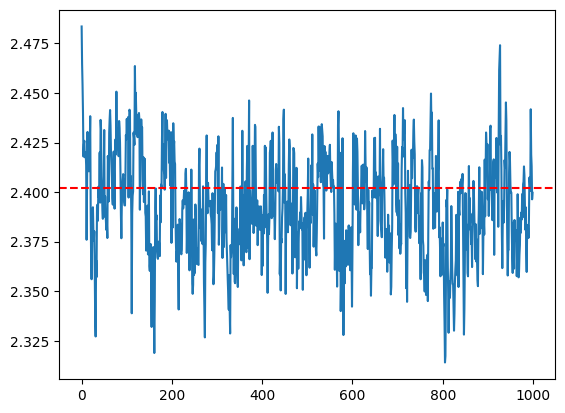

In [32]:

jj = 7
for ii in range(1):
    plt.plot(samples[jj, :,ii+3, 0])
plt.axhline(true_params['lf'][jj], c='r', ls='--')

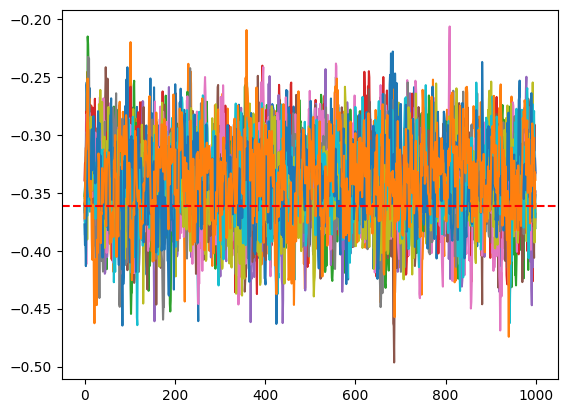

In [544]:
jj = 44
for ii in range(12):
    plt.plot(samples[jj, :,ii, 1])
plt.axhline(true_params['lhlr'][jj], c='r', ls='--')

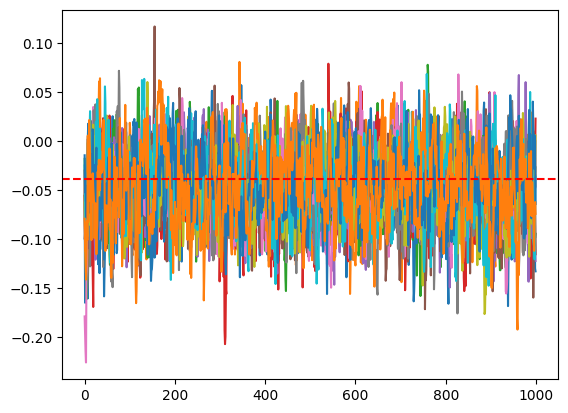

In [545]:

jj = 55
for ii in range(12):
    plt.plot(samples[jj, :,ii, 4])
plt.axhline(true_params['e1'][jj], c='r', ls='--')

In [546]:
samples.transpose(0, 1, 3, 2).shape

(500, 1000, 6, 12)

In [550]:
# efficiency


samples_dict = {} 
for jj, p in enumerate(_params_order):
    samples_dict[p] = samples[:, 100:, :, jj].transpose(0, 2, 1).reshape(500, 12, 900)


ess_out = get_ess_all(samples_dict)
rhat_out = get_rhat_all(samples_dict)

INFO: Computing ESS...


100%|██████████| 500/500 [00:08<00:00, 56.14it/s]


INFO: Computing R-hats...


100%|██████████| 500/500 [00:00<00:00, 1065.28it/s]


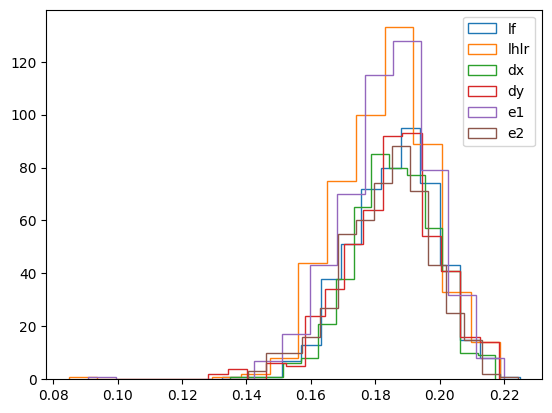

In [551]:
for p in _params_order:
    plt.hist(ess_out[p], bins=15, histtype='step', label=p)
plt.legend()

In [552]:
ess_out['dx'].mean()

np.float64(0.18578067814864843)

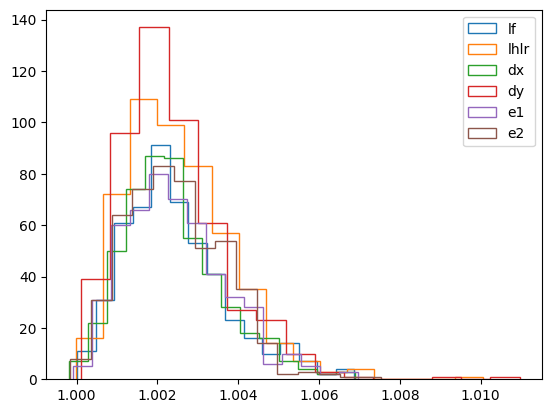

In [553]:
for p in _params_order:
    plt.hist(rhat_out[p], bins=15, histtype='step', label=p)
plt.legend()

In [554]:
for p in _params_order:
    print(sum(rhat_out[p] > 1.01))

0
1
0
1
0
0


In [556]:
import pickle
with open("samples_hmc_500.pkl", 'wb') as fp: 
    pickle.dump(samples, fp)

In [2]:
import pickle
with open("samples_hmc_500.pkl", 'rb') as fp: 
    samples=pickle.load(fp)

In [3]:
samples.shape

(500, 1000, 12, 6)

# Run in script

In [7]:
from bpd.io import load_dataset
import numpy as np 

In [8]:
timings = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp94/timing.npz")
timings

{'1': array(5.00761008),
 '5': array(50.47839522),
 '10': array(74.85844064),
 '25': array(99.1295774),
 '50': array(202.49701643),
 '100': array(365.37652278),
 '250': array(821.70343471),
 '500': array(1440.4497304)}

In [9]:
np.array([int(x) for x in list(timings.keys())])

array([  1,   5,  10,  25,  50, 100, 250, 500])

In [3]:
load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp94/samples.npz")['lf'].shape

(500, 12, 600)